# PHY 3310 - Quantum Mechanics
# Time evolution for single spins
-----------------------------------------------------------

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *
%matplotlib inline

In this activity, we are going to explore the simulation of time evolution in single spin systems. For a quantum state $\left|\psi\right\rangle$, time evolution is governed by the Schrödinger equation,

$$i\hbar \frac{d}{dt}\left|\psi\right\rangle = \hat{H}\left|\psi\right\rangle.$$

For now, we'll assume a time-independent Hamiltonian. In particular, the relevant Hamiltonian for a spin in a constant magnetic field ${\bf B}$ is

$$\hat{H} = -\lambda {\bf B}\cdot\hat{\bf S},$$

where $\lambda$ is some constant proportional to the magnetic moment of the spin and $\hat{\bf S} = \hat{S}^{x}\hat{\bf x} +  \hat{S}^{y}\hat{\bf y} + \hat{\bf z} \hat{S}^{z}\hat{\bf z}$. 

As an example, let's suppose $\left|\psi(0)\right\rangle = \left|+\right\rangle$ and ${\bf B} = B_{0}\hat{y}$ for some constant $B_{0}$. For this case, the Hamiltonian simplifies to

$$\hat{H} \rightarrow -\frac{\lambda B_{0}\hbar}{2}\sigma^{y} \;\;\dot{=}\;\; -\hbar\omega\left(\begin{array}{cc} 0 & -i\\ i & 0\end{array}\right),$$

where $\omega \equiv \lambda B_{0}/2$. The fundamental problem in quantum dynamics is to predict the probabilities of measurement outcomes or expectation values at some time $t$ given a Hamiltonian $\hat{H}$ and an initial state for the system, $\left|\psi(0)\right\rangle$. We first consider this simple example for which it is straightforward to solve the Schrödinger equation exactly. A formal integration gives

$$\left|\psi(t)\right\rangle = e^{-i\hat{H}t/\hbar}\left|\psi(0)\right\rangle$$,

where 

$$e^{-i\hat{H}t/\hbar} = e^{i\omega t\sigma^{y}}.$$

We can compute the exponential of a matrix by using the Taylor expansion of the exponential function as a definition.

$$e^{i\omega t\sigma^{y}} \equiv \hat{I} + i\omega t\sigma^{y} + \frac{(i\omega t\sigma^{y})^{2}}{2!} + \frac{((i\omega t\sigma^{y})^{3}}{3!} + \frac{(i\omega t\sigma^{y})^{4}}{4!} + \cdots.$$

Using $(\sigma^{y})^{2} = \hat{I}$ and $i^{2} = -1$, one may group even and odd terms

$$e^{i\omega t\sigma^{y}} = \hat{I}\left[1 - \frac{(\omega t)^{2}}{2!} + \frac{(\omega t)^{4}}{4!} + \cdots\right] + i\sigma^{y}\left[\omega t - \frac{(\omega t)^{3}}{3!} + \frac{(\omega t)^{5}}{5!} + \cdots\right].$$

The series in brackets are cosine and sine Taylor expansions, respectively. Writing out $\hat{I}$ and $\sigma^{y}$ as explicit matrices, we get

$$e^{i\omega t\sigma^{y}} = \hat{I}\cos(\omega t) + i\sigma^{y}\sin(\omega t) \;\;\dot{=}\;\; \left(\begin{array}{cc} \cos(\omega t) & \sin(\omega t)\\ -\sin(\omega t) & \cos(\omega t)\end{array}\right)$$

Now recall the general $\hat{U}(\theta,\phi,\lambda)$ gate 

$$\hat{U}(\theta,\phi,\lambda) \;\;\dot{=} \left(\begin{array}{cc} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\lambda + \phi)}\cos\frac{\theta}{2}\end{array}\right)$$

Then the time evolution is equivalent to the following $\hat{U}$ gate:

$$e^{-i\hat{H}t/\hbar} = \hat{U}(2\omega t,\pi,\pi),$$

or $\left|\psi(t)\right\rangle = \hat{U}(2\omega t,\pi,\pi)\left|+\right\rangle$. Exponentiating the Hamiltonian explicitly is rarely the most efficient way to solve for time dynamics analytically. See one of the [many](https://www.springer.com/gp/book/9780306447907) [excellent](https://www.pearson.com/us/higher-education/program/Mc-Intyre-Quantum-Mechanics/PGM64990.html) [textbooks](https://www.cambridge.org/highereducation/books/introduction-to-quantum-mechanics/990799CA07A83FC5312402AF6860311E#overview) on QM (or just Section IIA in [this paper](https://linus.highpoint.edu/~jlancaster/papers/su3.pdf) paper) for the standard approach. But this approach does lend itself to an efficient quantum circuit design for calculating spin dynamics.

The basic features of the circuit will be:

1. Generate the initial quantum state $\left|\psi(0)\right\rangle$ through an appropriate unitary transformation of the default initialization $\left|+\right\rangle$.
2. Perform time evolution by applying the gate(s) corresponding to $e^{-i\hat{H}t/\hbar}$.
3. Measure desired observables by appropriate rotation followed by measurement in computational basis.

For our first example, we take $\left|\psi(0)\right\rangle = \left|+\right\rangle$, so no rotation is required before performing step 2. In this first example, let us compute the expectation values $\left\langle \hat{S}^{x}\right\rangle$, $\left\langle \hat{S}^{y}\right\rangle$, $\left\langle \hat{S}^{z}\right\rangle$. To be economical, we can actually embed three copies of the single-spin circuit which only differ in the final gates which select the appropriate spin component for measurement. 

In order to measure the system at a range of time values (say $0\leq \omega t\leq 2\pi$), we can define $\tau = \omega t$ as a parameter.

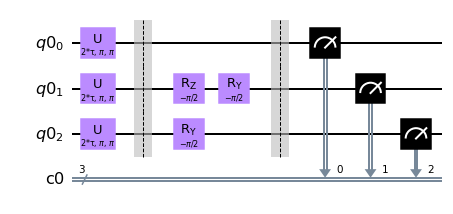

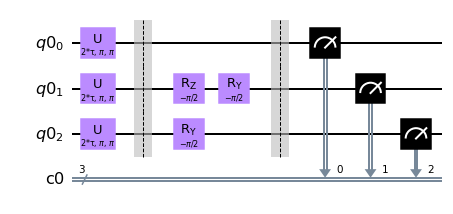

In [4]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc = QuantumCircuit(qr,cr) 

#no initial unitary transformation since |ψ(0)> = |+>

timecirc.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

Next, we define the range for $\tau$ and run on the simulator for some number of shots.

In [22]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcounts = job.result().get_counts()



Now we must pay the price for lumping three separate single-spin circuits onto a single three-spin circuit. Recall that the measurements will consist of which (total) state was counted, which specifies the state of all three spins in one three-character output. For instance, ```'000'``` refers to all three spin components being measured as up, while ```'001'``` refers to the $x$ and $y$ components being measured $+\frac{\hbar}{2}$, while the $z$ component was measured as $-\frac{\hbar}{2}$. At each time step we are interested in the overall counts for each component indepedently from the states of the others. Later, we will allow interactions between individual spins so that the entire configuration becomes important. But for now, we need to tally the +/- counts for each component while ignoring the states of the others.

For example, to obtain $\left\langle \hat{S}^{x}\right\rangle$, we need to compute

$$\left\langle \hat{S}^{x} \right\rangle = \frac{(\mbox{no. of 0 measurements})\times \frac{\hbar}{2} + (\mbox{no. of 1 measurements})\times \left(-\frac{\hbar}{2}\right)}{N_{shots}}$$ 

The number of '0' measurements refers only to the first spin, so we need to add contributions from ```'000'```, ```'001'```, ```'010'```, and ```'011'```. The remaining four states have a '1' in the first slot, so the sum of these represents the total number of shots for which this spin projection came out as $-\frac{\hbar}{2}$. Thus if we label the number of ```000``` measurements as $\texttt{c000}$ and similarly for the other seven states,

$$\left\langle \hat{S}^{x}\right\rangle = \frac{\hbar}{2}\frac{\texttt{c000} + \texttt{c001} + \texttt{c010}+ \texttt{c011}- \texttt{c100}- \texttt{c101}- \texttt{c110}- \texttt{c111}}{N_{shots}}.$$

Similar reasoning applies to the other components. I should emphasize that you don't <i>have</i> to do it this way. You could just as easily create three single-qubit circuits in which each circuit returned simple counts for a single component of spin. The tradeoff is that you would have to send three separate circuits to the quantum hardware.

In [5]:
c000 = np.array(list(map(lambda c: c.get('000', 0), simcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), simcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), simcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), simcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), simcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), simcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), simcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), simcounts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

We can now plot the spin expectation values as functions of $\theta$. In this simple case, it's useful to verify that this simulated circuit is actually simulating what we <i>think</i> it is. Since the time-dependent state can be computed exactly, it's straightforward to compute the time-dependent expectation values analytically (see derivation above Eq. (13) in [this](https://linus.highpoint.edu/~jlancaster/papers/su3.pdf) paper or any QM textbook),

$$\left\langle \hat{S}^{x}\right\rangle = -\frac{\hbar}{2}\sin(2\omega t),$$
$$\left\langle \hat{S}^{z}\right\rangle = \frac{\hbar}{2}\cos(2\omega t),$$

while $\left\langle \hat{S}^{y}\right\rangle = 0$. So we can plot the simulator results alongside theoretical predictions:

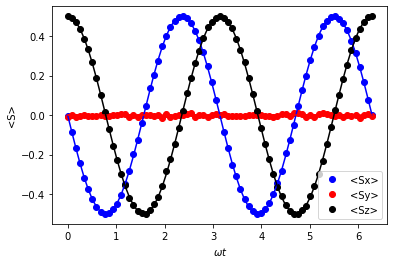

In [6]:
plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

Turns out it looks pretty good! Next, we can send this to actual quantum hardware.

In [23]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-13 17:55:24,869: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
qcomp = provider.get_backend('ibmq_bogota')

job = execute(timecirc, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

Job Status: job has successfully run


It's never a bad idea to print the job ID so it can be accessed later. What follows is the same post-processing we used for the simulator and a similar plot.

In [10]:
job.job_id()

'613d0d348228224fe7e2122a'

In [11]:
#Data stored in job '613d0d348228224fe7e2122a' (ibmq_bogota)
cq000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
cq001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
cq010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
cq011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
cq100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
cq101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
cq110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
cq111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(cq000+cq001+cq010+cq011-cq100-cq101-cq110-cq111)/Nshots
Syq = 0.5*(cq000+cq001+cq100+cq101-cq010-cq011-cq110-cq111)/Nshots
Szq = 0.5*(cq000+cq010+cq100+cq110-cq001-cq011-cq101-cq111)/Nshots

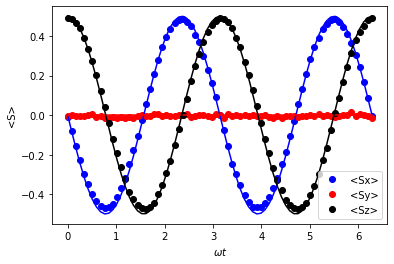

In [14]:
plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

What we see looks <i>pretty</i> good, but you'll notice that the actual data never quite gets as close to $\pm \frac{\hbar}{2}$ as the simulated data did. Errors tend to reduce coherence, and they're often quite noticeable at the peaks.

With suitable relabeling of axes, the most general Hamiltonian of the form $\hat{H} = -\lambda {\bf B}\cdot\hat{\bf S}$ one would need to consider would only depend on the relative angle between the initial spin projection and the magnetic field. For a given coordinate system, any state can be written in the form $\left|\psi(0)\right\rangle= \cos\frac{\theta_{0}}{2}\left|+\right\rangle + e^{i\phi_{0}}\sin\frac{\theta_{0}}{2}\left|-\right\rangle$, which has expectation value $+\frac{\hbar}{2}$ for spin projection measured along the direction given by $\hat{n}(\theta_{0},\phi_{0})$. So we could simply relabel the $z$ axis to point in this direction, take the state to be $\left|+\right\rangle$, and then work out the new orientation of the magnetic field in this coordinate system. 

But it's an instructive exercise to use what we've built to tackle the general problem of computing the time evolution of an arbitrary spin state in an arbitrary magnetic field.

<b>Exercise: </b> Suppose ${\bf B} = B_{0}\hat{x}$. The corresponding time-evolution operator takes the form

$$\exp\left[-i\hat{H}t/\hbar\right] = \exp\left[i\omega t\sigma^{x}\right]$$

Calculate the explicit matrix representation of this operator and write it in terms of the gate $\hat{U}(\theta,\phi,\lambda)$. Then do the same for ${\bf B} = B_{0}\hat{z}$.

<b>Solution: </b> Performing a Taylor expansion of the matrix exponential, one finds (after identical steps taken above and making use of $(\sigma^{x})^{2} = \hat{I}$)
    
$$\exp\left[i\omega t\sigma^{x}\right] = \hat{I}\left[1-\frac{(\omega t)^{2}}{2!} + \frac{(\omega t)^{4}}{4!} + \cdots\right] + i\sigma^{x}\left[\omega t - \frac{(\omega t)^{3}}{3!} + \frac{(\omega t)^{5}}{5!} + \cdots\right] = \cos(\omega t)\hat{I} + i\sin(\omega t)\sigma^{x}$$

Thus

$$\exp\left[i\omega t\sigma^{x}\right] \dot{=} \left(\begin{array}{cc} \cos(\omega t) & i\sin(\omega t)\\ i\sin(\omega t) & \cos(\omega t)\end{array}\right)$$

Upon comparing this to the form of $\hat{U}(\theta,\phi,\lambda)$, we see

$$\exp\left[i\omega t\sigma^{x}\right] = \hat{U}\left(2\omega t, \frac{\pi}{2}, -\frac{\pi}{2}\right).$$

Repeating the broad strokes for $\sigma^{z}$,

$$\exp\left[i\omega t\sigma^{z}\right] = \cos(\omega t)\hat{I} + i\sin(\omega t)\sigma^{z} \;\;\dot{=}\;\; \left(\begin{array}{cc} \cos(\omega t)+i\sin(\omega t) & 0 \\ 0 & \cos(\omega t) - i\sin(\omega t)\end{array}\right)  \;\;=\;\;\left(\begin{array}{cc} e^{i\omega t} & 0 \\ 0 & e^{-i\omega t}\end{array}\right)$$

Representing this as a unitary gate is a little trickier, but if we factor out $e^{i\omega t}$, we see that

$$\exp\left[i\omega t\sigma^{z}\right] = e^{i\omega t}\hat{U}(0,0,-2\omega t)$$

Recalling that the overall phase of a state is not measureable, we can simply ignore that prefactor. Thus

$$\exp\left[i\omega t\sigma^{x}\right] \Rightarrow \hat{U}\left(2\omega t, \frac{\pi}{2}, -\frac{\pi}{2}\right).$$
$$\exp\left[i\omega t\sigma^{y}\right] \Rightarrow \hat{U}\left(2\omega t, \pi, \pi\right).$$
$$\exp\left[i\omega t\sigma^{z}\right] \Rightarrow \hat{U}\left(0,-\omega t, -\omega t\right).$$

At first glance, it might seem as we have all we need to compute the time-evolution operator for a general magnetic field direction, since 

$${\bf B}\cdot\hat{\bf S} = B_{x}\hat{S}^{x} + B_{y}\hat{S}^{y} + B_{z}\hat{S}^{z}$$

So as a simple case, consider ${\bf B} = \frac{B_{0}}{\sqrt{2}}\hat{\bf x} + \frac{B_{0}}{\sqrt{2}}\hat{\bf y}$. Turning the crank, we find

$$\exp\left[-i\hat{H}t/\hbar\right] = \exp\left[i\frac{\omega t}{\sqrt{2}}\sigma^{x} + i\frac{\omega t}{\sqrt{2}}\sigma^{y}\right]$$

One would like to split the exponential according to $e^{a+b} = e^{a}e^{b}$ so that

$$\exp\left[-i\hat{H}t/\hbar\right] \longrightarrow \exp\left[i\frac{\omega t}{\sqrt{2}}\sigma^{x}\right]\exp\left[i\frac{\omega t}{\sqrt{2}}\sigma^{y}\right] \longrightarrow \hat{U}\left(\sqrt{2}\omega t, \pi, \pi\right)\hat{U}\left(\sqrt{2}\omega t, \frac{\pi}{2}, -\frac{\pi}{2}\right)$$

But for <i>matrices</i>, it's only true that $e^{\hat{A}+\hat{B}} = e^{\hat{A}}e^{\hat{B}}$ <i>if</i> $\hat{A}$ and $\hat{B}$ commute, $\left[\hat{A},\hat{B}\right] = 0$. Unfortunately for us, it's well known (and easily verified) that $\left[\sigma^{x},\sigma^{y}\right] = 2i\sigma^{z} \neq 0$.

This leaves two options which we will explore:

1. Evaluate $\hat{U}(\theta,\phi,\lambda)$ for the general spin direction $\hat{n}(\theta,\phi)$ since we can write ${\bf B}\cdot\hat{\bf S} = B_{0}\hat{S}^{\hat{n}}$ for ${\bf B} = B_{0}\hat{\bf n}$.

2. Work carefully with the commutators to obtain a correct scheme to decompose this exponential. In the end, this approach will lead us to a fairly general approach used to attack systems for which analytic solutions are not available--and hence, for which approach (1) will fail.

### Time evolution operator for arbitrary magnetic field

It's possible to compute the general case ${\bf B} = B_{0}\hat{\bf n}$, but implementation is somewhat tricky due to a limited number of built-in functions to act on ```Parameter``` objects. Instead of tackling that, let's just look closely at a particular example of a magnetic field with more than one component:

$${\bf B} = \frac{B_{0}}{\sqrt{2}}\hat{\bf x} + \frac{B_{0}}{\sqrt{2}}\hat{\bf y}$$

This corresponds to $\theta = \frac{\pi}{2}$, $\phi = \frac{\pi}{4}$, so

$$\exp\left[-i\hat{H}t/\hbar\right] = \hat{U}\left(2\omega t, \frac{3\pi}{4}, -\frac{3\pi}{4}\right)$$

Analytically, we can write out the expected spin components as 

$$\left\langle \hat{S}^{x} \right\rangle = \frac{\hbar}{2}\cos\frac{3\pi}{4}\sin(2\omega t)$$
$$\left\langle \hat{S}^{y} \right\rangle = \frac{\hbar}{2}\sin\frac{3\pi}{4}\sin(2\omega t)$$
$$\left\langle \hat{S}^{z} \right\rangle = \frac{\hbar}{2}\cos(2\omega t)$$

Try showing that! It's a fun exercise to build confidence in your grasp on quantum (single) spin dynamics.

<b>Exercise: </b> Implement the above case as a circuit, (a) making a plot of (QASM) simulation predictions alongside the theoretical curves and then (b) plotting the actual results from quantum hardware alongside theory. Remember to print out the job ID for future retrieval. 

We consider the particular example:

$${\bf B} = \frac{B_{0}}{\sqrt{2}}\hat{\bf x} + \frac{B_{0}}{\sqrt{2}}\hat{\bf y}$$

This corresponds to $\theta = \frac{\pi}{2}$, $\phi = \frac{\pi}{4}$, so

$$\exp\left[-i\hat{H}t/\hbar\right] = \hat{U}\left(2\omega t, \frac{3\pi}{4}, -\frac{3\pi}{4}\right)$$

In [24]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

timecirc.u(2*tau,np.pi/2+ϕ,-np.pi/2-ϕ,qr)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw()

┌───────────────────┐ ░                          ░ ┌─┐      
q200_0: ┤ U(2*τ,3π/4,-3π/4) ├─░──────────────────────────░─┤M├──────
        ├───────────────────┤ ░ ┌──────────┐┌──────────┐ ░ └╥┘┌─┐   
q200_1: ┤ U(2*τ,3π/4,-3π/4) ├─░─┤ RZ(-π/2) ├┤ RY(-π/2) ├─░──╫─┤M├───
        ├───────────────────┤ ░ ├──────────┤└──────────┘ ░  ║ └╥┘┌─┐
q200_2: ┤ U(2*τ,3π/4,-3π/4) ├─░─┤ RY(-π/2) ├─────────────░──╫──╫─┤M├
        └───────────────────┘ ░ └──────────┘             ░  ║  ║ └╥┘
 c10: 3/════════════════════════════════════════════════════╩══╩══╩═
                                                            0  1  2

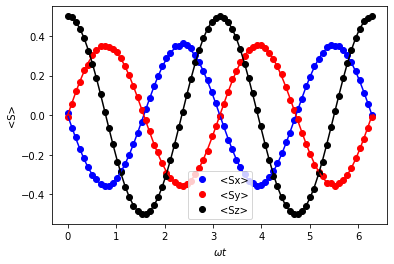

In [25]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), simcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), simcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), simcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), simcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), simcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), simcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), simcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), simcounts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

Job Status: job has successfully run


account._job_result_object_storage:WARNING:2021-09-13 23:43:31,605: An error occurred while sending download completion acknowledgement: "HTTPSConnectionPool(host='api-qcon.quantum-computing.ibm.com', port=443): Read timed out. (read timeout=None)"


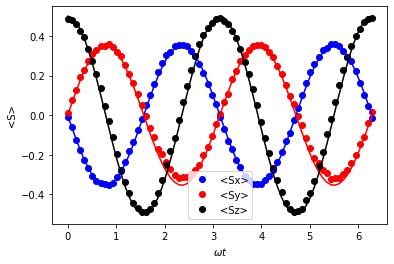

In [28]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qcomp = provider.get_backend('ibm_lagos')

job = execute(timecirc, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

Now let's revisit the problematic decomposition $e^{\hat{A}+\hat{B}} \neq e^{\hat{A}}e^{\hat{B}}$. 

<b>Exercise: </b> Instead of the exact time-evolution gate $\hat{U}\left(2\omega t, \frac{3\pi}{4},-\frac{3\pi}{4}\right)$, use either the QASM simulator or real hardware to simulate time evolution with the following sequence of two gates: $\hat{U}\left(\sqrt{2}\omega t, \pi, \pi\right)\hat{U}\left(\sqrt{2}\omega t, \frac{\pi}{2}, -\frac{\pi}{2}\right)$. How do the results compare to the theoretical predictions?

<b>Solution: </b>

In [10]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

timecirc0.u(np.sqrt(2)*tau,np.pi/2,-np.pi/2,qr)
timecirc0.u(np.sqrt(2)*tau,np.pi,-np.pi,qr)
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

┌───────────────────────────────┐┌───────────────────────────┐ ░ »
q21_0: ┤ U(1.4142135623731*τ,π/2,-π/2) ├┤ U(1.4142135623731*τ,π,-π) ├─░─»
       ├───────────────────────────────┤├───────────────────────────┤ ░ »
q21_1: ┤ U(1.4142135623731*τ,π/2,-π/2) ├┤ U(1.4142135623731*τ,π,-π) ├─░─»
       ├───────────────────────────────┤├───────────────────────────┤ ░ »
q21_2: ┤ U(1.4142135623731*τ,π/2,-π/2) ├┤ U(1.4142135623731*τ,π,-π) ├─░─»
       └───────────────────────────────┘└───────────────────────────┘ ░ »
 c2: 3/═════════════════════════════════════════════════════════════════»
                                                                        »
«                                ░ ┌─┐      
«q21_0: ─────────────────────────░─┤M├──────
«       ┌──────────┐┌──────────┐ ░ └╥┘┌─┐   
«q21_1: ┤ RZ(-π/2) ├┤ RY(-π/2) ├─░──╫─┤M├───
«       ├──────────┤└──────────┘ ░  ║ └╥┘┌─┐
«q21_2: ┤ RY(-π/2) ├─────────────░──╫──╫─┤M├
«       └──────────┘             ░  ║  ║ └╥┘
« c2: 3/════════════════════════════╩══╩══╩═
«                                   0  1  2

Job Status: job has successfully run


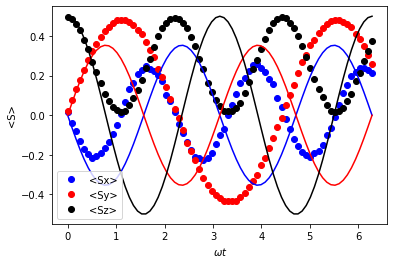

In [11]:
qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()


In [12]:
job.job_id()

'613eb9c65d45560735254ca0'

If run correctly, you should see that the actual (simulated or quantum computation) results <i>do</i> follow the theoretical predictions at short times before deviating substantially. For short time steps, we <i>can</i> approximate the full operator by a sequence of noncommuting operators. Taking the full time evolution operator to be of the form $\hat{U} = \exp\left[it(\hat{A}+\hat{B})\right]$ for $\left[\hat{A},\hat{B}\right] \neq 0$. It is possible to show that

$$\exp\left[it\left(\hat{A}+\hat{B}\right)\right] = \lim_{n\rightarrow\infty}\left(\exp\left[i\frac{t}{n}\hat{A}\right]\left[i\frac{t}{n}\hat{A}\right]\right)^{n}$$

That is, we <i>should</i> be able to get increasingly accurate results by slicing up the time step into many substeps. The above expression is known as the <b>Lie-Trotter formula</b>, and the main idea is to compute (approximately) the time evolution of the quantum state at time $t$ by taking $n$ small steps of size $\frac{t}{n}$ using the product of simpler operator exponentials. For $n$ sufficiently large, the approximate result should converge to the exact result. This process is sometimes referred to as <b>Trotterization</b>.

Before diving in, it's worth asking <i>why</i> one would do this when the exact result is much simpler. The interactions of a single spin with an external magnetic field are special in that it is possible to obtain the exact time evolution operator. For multiple spins, the types of possible interactions <i>between</i> spins result in significantly more complicated Hamiltonians for which this exact analysis is not generally possible. But by decomposing (approximately) the exponential of a fairly complicated Hamiltonian into a series of simple Trotterized factors, it becomes possible to simulate much more interesting dynamics. Indeed, the anticipated value of future quantum devices is that such simulations will be much more efficient than state-of-the-art computations on classical devices.

Below is an example of the Trotterization scheme where the number of Trotter steps is set to ```ntrot```. 

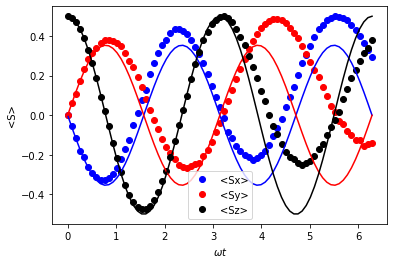

In [5]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 5

for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()


job = execute(timecirc0, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

counts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), counts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), counts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), counts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), counts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), counts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), counts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), counts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), counts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

<b>Exercise: </b> Rerun the above cell, gradually increasing ```ntrot``` until the simulated results match the theoretical predictions (at least, visually). How large did you have to set ```ntrot```?

$n=10$

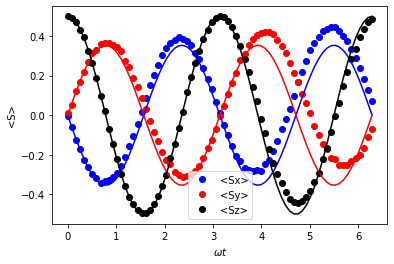

In [6]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 10

for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()


job = execute(timecirc0, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

counts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), counts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), counts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), counts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), counts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), counts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), counts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), counts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), counts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

$n=50$

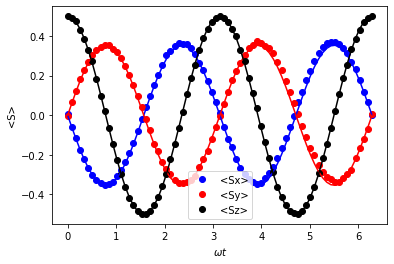

In [7]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 50

for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()


job = execute(timecirc0, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

counts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), counts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), counts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), counts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), counts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), counts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), counts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), counts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), counts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

$n=100$

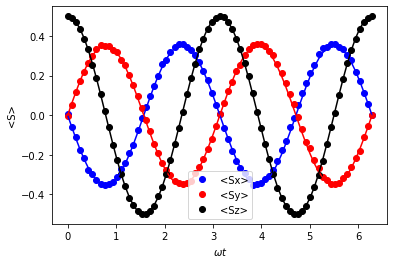

In [8]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 100

for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()


job = execute(timecirc0, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

counts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), counts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), counts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), counts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), counts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), counts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), counts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), counts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), counts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

At this point, the simulation seems (visually) to have converged.

o far, so good. Problem solved.

But here comes the bad news: the larger the value of ```ntrot```, the larger the "depth" of the circuit. For example, even with ```ntrot=5```, we're applying five times as many gates to perform time evolution as we did with a single step. The deeper the circuit, the longer the execution takes, and the more time the system has to lose decoherence. Additionally, repeated application of noisy or error-prone gates will further degrade the result. 

We find ourselves backed into a corner in which we must decide how to minimize overall misery. More Trotter steps should make for more accurate calculations, but more Trotter steps will also increase errors due to hardware limitations. As a final task, we're going to crowdsource to find an optimal value of ```ntrot``` using the efforts of you and your peers.

<b>(Group) exercise: </b> For a particular device, what value of ```ntrot``` gives the <i>best</i> agreement between theory and experiment? Coordinate with students around you so that you have a set of values to try. Individually, you don't need to perform all these computations yourself (see below), but you can if you wish.

<b>Important:</b> Make sure to print the job ID for each job performed along with a note of what the value of ```ntrot``` was <i>and</i> the actual device used. You can share the job IDs with your peers (in whatever way is most convenient) so that anyone can have access to the raw data. It is important to compare only jobs performed on the same device (ideally, performed roughly around the same time since machines are recalibrated regularly). 

<b>Solution: </b> Here's what I find:

$n = 5$ Trotter

Job Status: job has successfully run


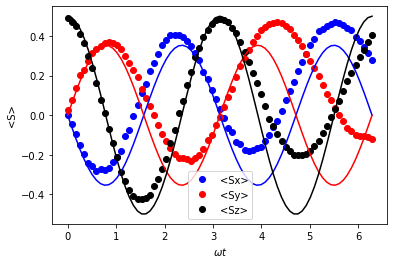

613ebb448228223a7ae22161


In [13]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 5
for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

#job id: (ibmq_manila) '613ebb448228223a7ae22161'

print(job.job_id())

$n=10$

Job Status: job has successfully run


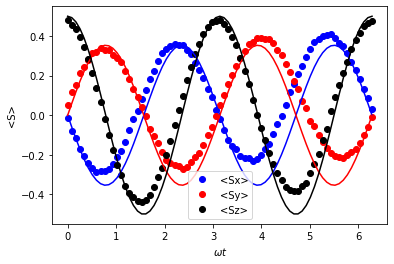

613ebc6fe3f91580a4349275


In [14]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 10
for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

#job id: (ibmq_manila) '613ebc6fe3f91580a4349275'

print(job.job_id())

$n=20$

Job Status: job has successfully run


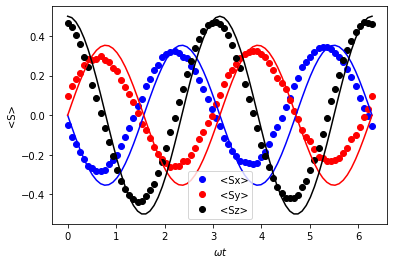

613ebd8dfd18233913858a81


In [15]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 20
for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

#job id: (ibmq_manila) '613ebd8dfd18233913858a81'

print(job.job_id())

$n=50$

Job Status: job has successfully run


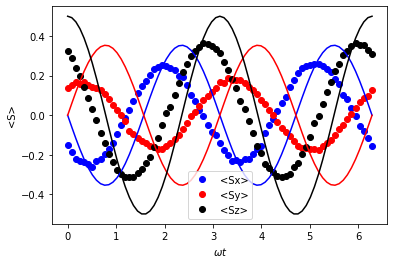

613ebed1a92e500a3f10e623


In [16]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 50
for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

#job id: (ibmq_manila) '613ebed1a92e500a3f10e623'

print(job.job_id())

$n=100$

Job Status: job has successfully run


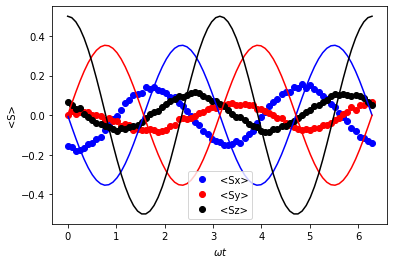

613ec1175d45562bb1254ce7


In [17]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

ntrot = 100
for i in range(0,ntrot):
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi/2,-np.pi/2,qr)
    timecirc0.u(np.sqrt(2)*tau/ntrot,np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()

qcomp = provider.get_backend('ibmq_manila')

job = execute(timecirc0, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(2*tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

#job id: (ibmq_manila) '613ec1175d45562bb1254ce7'

print(job.job_id())

Somewhere in the $N\sim\mathcal{O}(10)$ range, we hit a balance between the algorithm converging and the errors accumulating. This is a realistic tradeoff researchers must face in studying more complicated systems that <i>can't</i> be solved exactly.